<p align="center"><b><font size="6"> Macine Learning in practice</b></p>

In [53]:
!pip install scikit-learn
!pip install pandas numpy matplotlib transformers torch datasets imblearn tensorflow

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached tensorflow-2.19.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (4.0 kB)
Using cached tensorflow-2.19.0-cp311-cp311-macosx_12_0_arm64.whl (252.6 MB)


In [22]:
from sklearn.model_selection import train_test_split
import pandas as pd
random_seed = 42
import matplotlib.pyplot as plt
from transformers import pipeline

In [23]:
labelling_budgets=[16, 32, 64, 128, 256, 512, 1024]

# Data Processing

In [24]:
# IMDB Movie Reviews
train_path = "Raw Data/IMDB Movie Reviews/train_dataset.csv"
test_path = "Raw Data/IMDB Movie Reviews/test_dataset.csv"
unsupervised_path = "Raw Data/IMDB Movie Reviews/unsupervised_dataset.csv"

IMDB_train = pd.read_csv(train_path)
IMDB_test = pd.read_csv(test_path)
IMDB_unsupervised = pd.read_csv(unsupervised_path)


#Wikipedia Comments
wiki_comments_path = "Raw Data/Wikipedia Personal Attacks/attack_annotated_comments.tsv"
wiki_annotations_path = "Raw Data/Wikipedia Personal Attacks/attack_annotations.tsv"

wiki_comments = pd.read_csv(wiki_comments_path, sep='\t')
wiki_annotations = pd.read_csv(wiki_annotations_path, sep='\t')


In [25]:
IMDB_train

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [26]:
wiki_comments

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train
...,...,...,...,...,...,...,...
115859,699848324,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThese ...,2016,True,article,blocked,train
115860,699851288,NEWLINE_TOKENNEWLINE_TOKENThe Institute for Hi...,2016,True,article,blocked,test
115861,699857133,NEWLINE_TOKEN:The way you're trying to describ...,2016,True,article,blocked,train
115862,699891012,NEWLINE_TOKENNEWLINE_TOKEN== Warning ==NEWLINE...,2016,True,user,blocked,dev


In [27]:
wiki_data = wiki_comments

wiki_data["comment"] = wiki_data["comment"].str.replace("NEWLINE_TOKEN", "")
wiki_data = wiki_data.drop(columns=["ns", "sample", "year","rev_id"])
wiki_data = wiki_data.rename(columns={"logged_in": "label"})
wiki_data = wiki_data.rename(columns={"comment": "text"})
wiki_data["label"] = wiki_data["label"].map({False: 0, True: 1})

In [28]:
wiki_data

,text,label,split
0,`-This is not ``creative``. Those are the dic...,0,train
1,`:: the term ``standard model`` is itself less...,0,train
2,"True or false, the situation as of March 2002 ...",0,train
3,"Next, maybe you could work on being less cond...",1,dev
4,This page will need disambiguation.,1,train
...,...,...,...
115859,`These sources don't exactly exude a sense of ...,1,train
115860,The Institute for Historical Review is a peer-...,1,test
115861,:The way you're trying to describe it in this ...,1,train
115862,== Warning ==There is clearly a protectionist ...,1,dev


In [29]:
wiki_train = wiki_data[wiki_data['split'] == 'train']
wiki_train = wiki_train.drop(columns=["split"])
wiki_train
print(wiki_train['label'].value_counts())

wiki_test = wiki_data[wiki_data['split'] == 'test']
wiki_test = wiki_test.drop(columns=["split"])
print(wiki_test['label'].value_counts())

wiki_dev = wiki_data[wiki_data['split'] == 'dev']
wiki_dev = wiki_dev.drop(columns=["split"])
print(wiki_dev['label'].value_counts())

label
1    50846
0    18680
Name: count, dtype: int64
label
1    17262
0     5916
Name: count, dtype: int64
label
1    16810
0     6350
Name: count, dtype: int64


### Unbalanced dataset for IMDB

In [30]:
def unbalanced(df,p):
    df_neg = df[df['label'] == 0]
    df_pos = df[df['label'] == 1]
    
    n_pos = round(len(df_neg)*p/(1-p))
    df_pos = df_pos.sample(n=n_pos)
    df_unbalanced = pd.concat([df_neg, df_pos])

    # Shuffle
    df_unbalanced = df_unbalanced.sample(frac=1, random_state=42)
    
    print(df_unbalanced["label"].value_counts(normalize=True))
    print(len(df_unbalanced))
    return df_unbalanced

In [31]:
p=0.1

IMDB_train_balanced = IMDB_train
IMDB_train_unbalanced = unbalanced(IMDB_train, p)

IMDB_test_2, IMDB_dev =train_test_split(IMDB_test, test_size=0.5, random_state=42)

IMDB_test_balanced = IMDB_test_2
IMDB_test_unbalanced = unbalanced(IMDB_test_2, p)

IMDB_dev_balanced = IMDB_dev
IMDB_dev_unbalanced = unbalanced(IMDB_dev, p)

label
0    0.899993
1    0.100007
Name: proportion, dtype: float64
13889
label
0    0.9
1    0.1
Name: proportion, dtype: float64
6880
label
0    0.899986
1    0.100014
Name: proportion, dtype: float64
7009


In [32]:
imdb_datasets = {
    "train_balanced": IMDB_train_balanced,
    "train_unbalanced": IMDB_train_unbalanced,
    "test_balanced": IMDB_test_balanced,
    "test_unbalanced": IMDB_test_unbalanced,
    "dev_balanced": IMDB_dev_balanced,
    "dev_unbalanced": IMDB_dev_unbalanced
}

### Balanced dataset for Wikipedia

In [33]:
def balanced(df):
    df_neg = df[df['label'] == 0]
    df_pos = df[df['label'] == 1]
    
    n_pos = len(df_neg)
    df_pos=df_pos.sample(n=n_pos)
    df_balanced = pd.concat([df_neg, df_pos])
    
    # Shuffle
    df_balanced = df_balanced.sample(frac=1, random_state=42)
    
    print(df_balanced["label"].value_counts(normalize=True))
    print(len(df_balanced))
    return df_balanced

In [34]:
wiki_train_unbalanced = wiki_train
wiki_test_unbalanced = wiki_test
wiki_dev_unbalanced = wiki_dev

wiki_train_balanced = balanced(wiki_train_unbalanced)
wiki_test_balanced = balanced(wiki_test_unbalanced)
wiki_dev_balanced = balanced(wiki_dev_unbalanced)

label
1    0.5
0    0.5
Name: proportion, dtype: float64
37360
label
1    0.5
0    0.5
Name: proportion, dtype: float64
11832
label
1    0.5
0    0.5
Name: proportion, dtype: float64
12700


In [35]:
wiki_datasets = {
    "train_unbalanced": wiki_train_unbalanced,
    "test_unbalanced": wiki_test_unbalanced,
    "dev_unbalanced": wiki_dev_unbalanced,
    "train_balanced": wiki_train_balanced,
    "test_balanced": wiki_test_balanced,
    "dev_balanced": wiki_dev_balanced,
}

# Naive Bayes

In [38]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

def train_and_evaluate_nb(df_train, df_test,n=-1, text_col='text', label_col='label', random_seed=random_seed):

    df_train = df_train.dropna(subset=[text_col])
    df_test = df_test.dropna(subset=[text_col])
    if n > 0:
        df_train = df_train.sample(n=n, random_state=random_seed).reset_index(drop=True)
    # Extraction des textes et labels
    X_train_texts = df_train[text_col]
    y_train = df_train[label_col]

    X_test_texts = df_test[text_col]
    y_test = df_test[label_col]

    # Vectorisation du texte avec TF-IDF
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train_texts)
    X_test = vectorizer.transform(X_test_texts)

    # Entraînement du modèle Naive Bayes
    model_nb = MultinomialNB()
    model_nb.fit(X_train, y_train)

    # Prédictions et évaluation
    preds = model_nb.predict(X_test)
    #print("=== Évaluation du modèle ===")
    #print("Accuracy:", accuracy_score(y_test, preds))
    #print(classification_report(y_test, preds))

    f1_val = f1_score(y_test, preds, average='macro')

    return model_nb, f1_val,



In [39]:
model_nb, f1_scor = train_and_evaluate_nb(IMDB_train, IMDB_test)

print("=== Score F1 ===")
print(f1_scor)

=== Score F1 ===
0.8289532297820281


In [40]:
def plot_model_performance_by_budget(
    datasets_dict,
    model_fn,
    model_name="Naive Bayes",
    labelling_budgets= labelling_budgets,
    colors=("blue", "red", "green")
):

    f1_score_Balanced = []
    f1_score_HalfBalanced = []
    f1_score_UnBalanced = []

    for budget in labelling_budgets:
        # (a) Balanced train + balanced test
        _, f1 = model_fn(datasets_dict["train_balanced"], datasets_dict["test_balanced"], budget)
        f1_score_Balanced.append(f1)

        # (b) Balanced train + unbalanced test
        _, f1 = model_fn(datasets_dict["train_balanced"], datasets_dict["test_unbalanced"], budget)
        f1_score_HalfBalanced.append(f1)

        # (c) Unbalanced train + unbalanced test
        _, f1 = model_fn(datasets_dict["train_unbalanced"], datasets_dict["test_unbalanced"], budget)
        f1_score_UnBalanced.append(f1)

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    axes[0].plot(labelling_budgets, f1_score_Balanced, marker='o', color=colors[0], label=model_name)
    axes[0].set_title('(a) Balanced train and balanced test')
    axes[0].set_xlabel('Labelling budget')
    axes[0].set_ylabel('Macro F1 Score')
    axes[0].set_ylim(0, 1.0)
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(labelling_budgets, f1_score_HalfBalanced, marker='o', color=colors[1], label=model_name)
    axes[1].set_title('(b) Balanced train and unbalanced test')
    axes[1].set_xlabel('Labelling budget')
    axes[1].set_ylim(0, 1.0)
    axes[1].grid(True)
    axes[1].legend()

    axes[2].plot(labelling_budgets, f1_score_UnBalanced, marker='o', color=colors[2], label=model_name)
    axes[2].set_title('(c) Unbalanced train and unbalanced test')
    axes[2].set_xlabel('Labelling budget')
    axes[2].set_ylim(0, 1.0)
    axes[2].grid(True)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

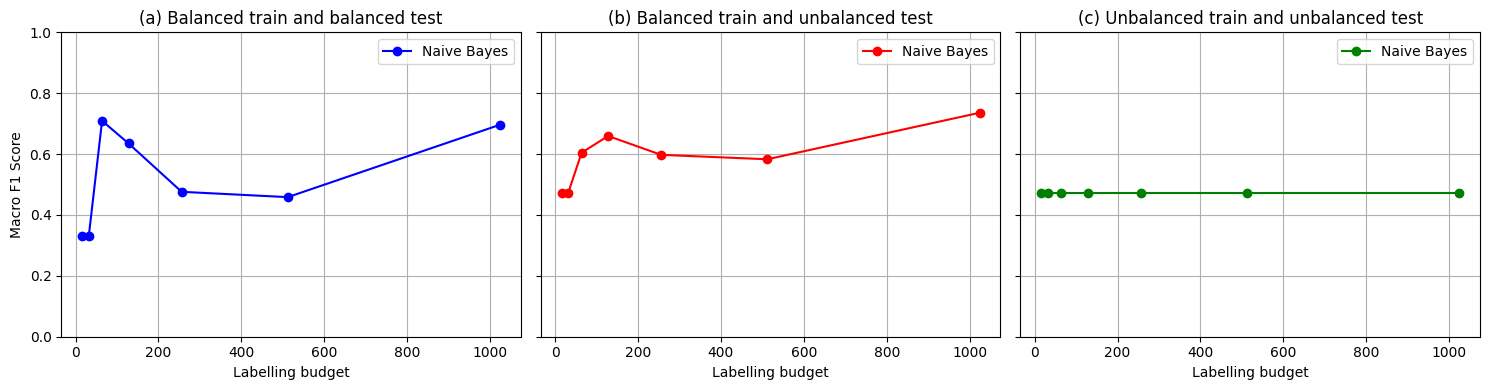

In [41]:
plot_model_performance_by_budget(imdb_datasets,train_and_evaluate_nb)

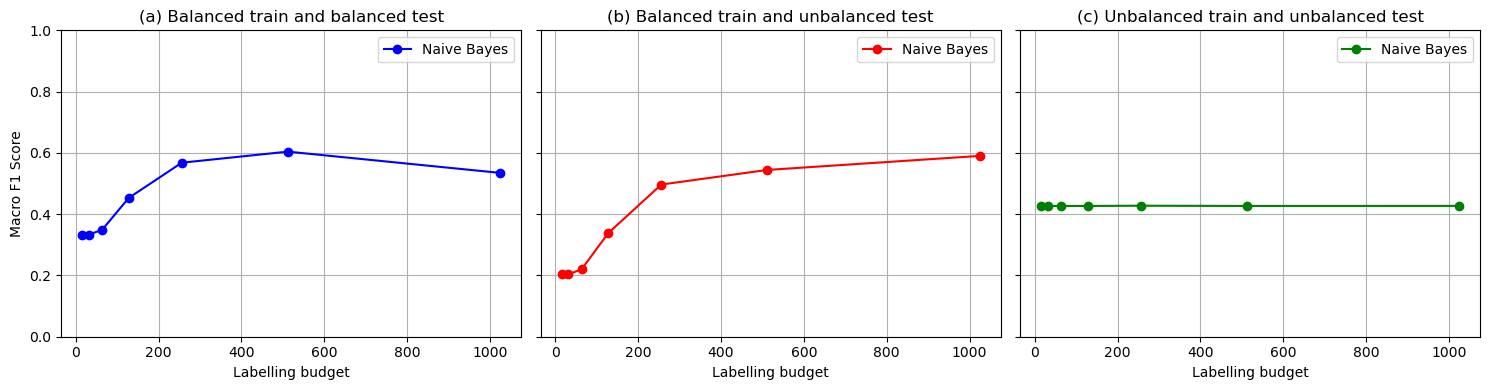

In [ ]:
plot_model_performance_by_budget(wiki_datasets,train_and_evaluate_nb)

# Weak Supervision

In [ ]:
from weak_supervision.labeling_functions import get_lfs

lfs_dict = get_lfs(path_keywords, path_annotations)
lf_list = list(lfs_dict.values())

from snorkel.labeling import PandasLFApplier
from snorkel.labeling.model import LabelModel

# 1. Load data
raw_data, n_classes = load_dataset(n_train, n_eval)
dataset = prepare_dataset(raw_data)

# 2. Load labeling functions
lfs_dict = get_lfs(path_keywords, path_annotations)
lf_list = list(lfs_dict.values())

# 3. Apply labeling functions
applier = PandasLFApplier(lfs=lf_list)
L_train = applier.apply(df=dataset["train"])
L_eval = applier.apply(df=dataset["eval"])

# 4. Train LabelModel
label_model = LabelModel(cardinality=n_classes, verbose=True)
label_model.fit(L_train=L_train, n_epochs=100, log_freq=10, seed=seed)

# 5. Predict on eval set
Y_eval = dataset["eval"].label.values
preds = label_model.predict(L=L_eval, tie_break_policy=tie_break_policy)

NameError: name 'convert_labels' is not defined

# Transfer Learning

In [68]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english",
)
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    torch_dtype=torch.float16,
)
inputs = tokenizer("I love using Hugging Face Transformers!", return_tensors="pt")

In [69]:
inputs

{'input_ids': tensor([[  101,  1045,  2293,  2478, 17662,  2227, 19081,   999,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [50]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score
from datasets import Dataset
import numpy as np
import torch
import random


def train_and_evaluate_transformer(df_train, df_test, n=-1, text_col='text', label_col='label', model_name='distilbert-base-uncased', random_seed=42):
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)

    # Sample n examples if needed
    if n > 0:
        df_train = df_train.sample(n=n, random_state=random_seed).reset_index(drop=True)

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased-finetuned-sst-2-english",
        num_labels=2,
        from_tf=True  # car le modèle est au format TensorFlow à la base
    )

    # Tokenization function
    def preprocess_function(examples):
        return tokenizer(examples[text_col], truncation=True, padding=True, max_length=512)

    # Convert to HuggingFace Dataset
    dataset_train = Dataset.from_pandas(df_train[[text_col, label_col]])
    dataset_test = Dataset.from_pandas(df_test[[text_col, label_col]])

    tokenized_train = dataset_train.map(preprocess_function, batched=True)
    tokenized_test = dataset_test.map(preprocess_function, batched=True)

    tokenized_train = tokenized_train.rename_column(label_col, "labels")
    tokenized_test = tokenized_test.rename_column(label_col, "labels")

    tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    training_args = TrainingArguments(
        output_dir="./results",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        logging_steps=10,
        evaluation_strategy="epoch",
        save_strategy="no",
        learning_rate=2e-5,
        seed=random_seed,
        disable_tqdm=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
    )

    trainer.train()

    # Prédictions
    preds = trainer.predict(tokenized_test)
    pred_labels = np.argmax(preds.predictions, axis=1)
    f1_val = f1_score(preds.label_ids, pred_labels, average='macro')

    return model, f1_val


In [63]:
model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased-finetuned-sst-2-english",
        num_labels=2
    )


In [64]:
plot_model_performance_by_budget(imdb_datasets,train_and_evaluate_transformer)

Loading a TensorFlow model in PyTorch, requires both PyTorch and TensorFlow to be installed. Please see https://pytorch.org/ and https://www.tensorflow.org/install/ for installation instructions.


ImportError: cannot import name 'TFGenerationMixin' from 'transformers.generation' (/Users/arnaudlamarque/Documents/Columbia_University/Machine Learning in practice/Cheap Learning/cheap_learning/.venv/lib/python3.11/site-packages/transformers/generation/__init__.py)

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd

# 1. Charger ton dataset IMDB
# Supposons que tu as déjà un DataFrame df_train et df_test avec colonnes 'text' et 'label'

# 2. Convertir en HuggingFace Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# 3. Charger le tokenizer DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# 4. Tokenizer les exemples

def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# 5. Charger le modèle pour la classification binaire
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# 6. Arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
)

# 7. Définir le trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 8. Entraînement
trainer.train()

# 9. Évaluation finale
metrics = trainer.evaluate()
print(metrics)


ImportError: cannot import name 'DistilBertTokenizerFast' from 'transformers' (unknown location)

# Prompt Engineering